Выполнить предсказание временного ряда. Разделить нужно не смешивая прошлое и будущее. 
Использовать sarima /  Prophet?
docker / собрать контейнер с tf + добавить свои данные
Electric_Production

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
# Загружаем датасет
df = pd.read_csv("Electric_Production.csv", parse_dates=["DATE"])
df.set_index("DATE", inplace=True)

# Разделение train/test (80% / 20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 317, Test size: 80


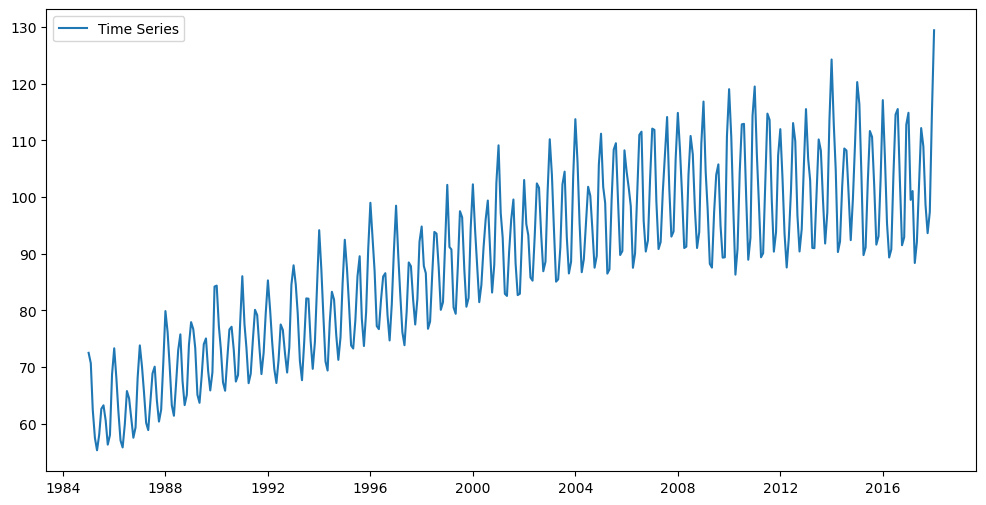

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Time Series")
plt.legend()
plt.show()


Оценим корреляцию данных для определения сезонности

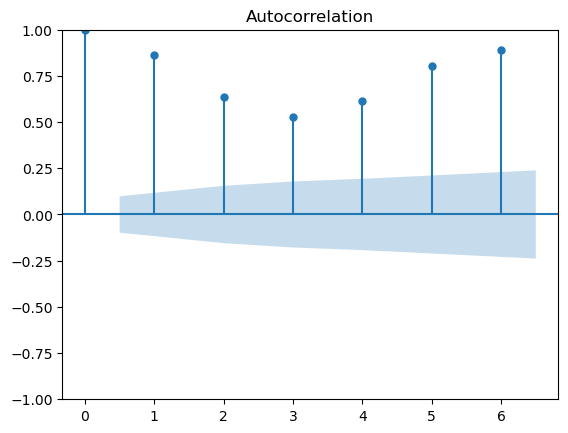

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df, lags=6) 
plt.show()


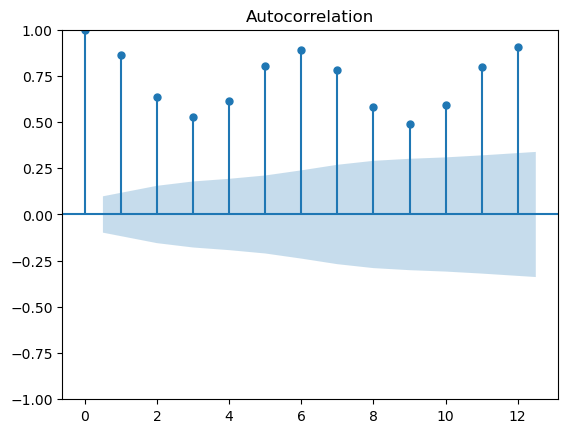

In [20]:
plot_acf(df, lags=12) 
plt.show()


Видно, что сезонность - 6 месяцев.

In [21]:
%%capture
# Подбор параметров

stepwise_model = auto_arima(train, seasonal=True, m=6,  # m - сезонность 
                            trace=False,  
                            suppress_warnings=True)



In [22]:
# Обучение модели
sarima_model = sm.tsa.statespace.SARIMAX(train,
                                         order=stepwise_model.order,
                                         seasonal_order=stepwise_model.seasonal_order,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False).fit()
print(sarima_model.summary())

d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        IPG2211A2N   No. Observations:                  317
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -656.832
Date:                           Sun, 16 Feb 2025   AIC                           1329.664
Time:                                   20:24:20   BIC                           1359.321
Sample:                               01-01-1985   HQIC                          1341.532
                                    - 05-01-2011                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3000      0.157      1.911      0.056      -0.008       0.608
ma.L1         -0.9559      0.130     -7.350

d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MAE: 4.64, RMSE: 5.89


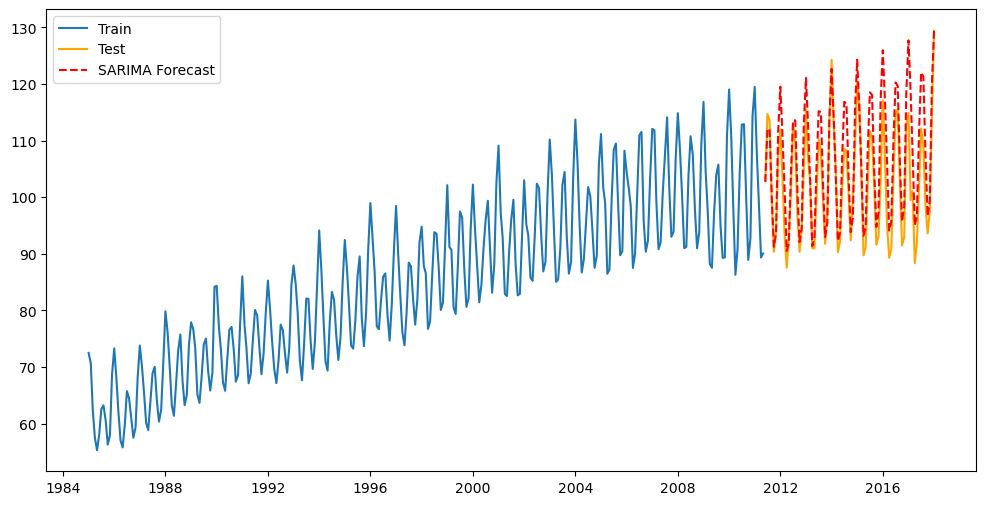

In [23]:
# Прогноз на test
sarima_forecast = sarima_model.forecast(steps=len(test))

# Метрики
mae_sarima = mean_absolute_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))

print(f"SARIMA MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

# График
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.legend()
plt.show()



Используем Prophet

In [12]:
len(test)

80

In [4]:
from prophet import Prophet

In [24]:
# Загружаем данные
df = pd.read_csv("Electric_Production.csv")

df = df.rename(columns={"DATE": "ds", "IPG2211A2N": "y"})  


df["ds"] = pd.to_datetime(df["ds"])

In [25]:
# Разделение на train/test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [26]:
# Создаём и обучаем модель Prophet
prophet = Prophet()
prophet.fit(train)

20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Создание датафрейма
future = prophet.make_future_dataframe(periods=len(test), freq="MS")
forecast = prophet.predict(future)

# Берём предсказания только для теста
prophet_forecast = forecast.iloc[-len(test):]["yhat"].values

# Метрики
mae_prophet = mean_absolute_error(test["y"], prophet_forecast)
rmse_prophet = np.sqrt(mean_squared_error(test["y"], prophet_forecast))

print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

Prophet MAE: 3.49, RMSE: 4.41


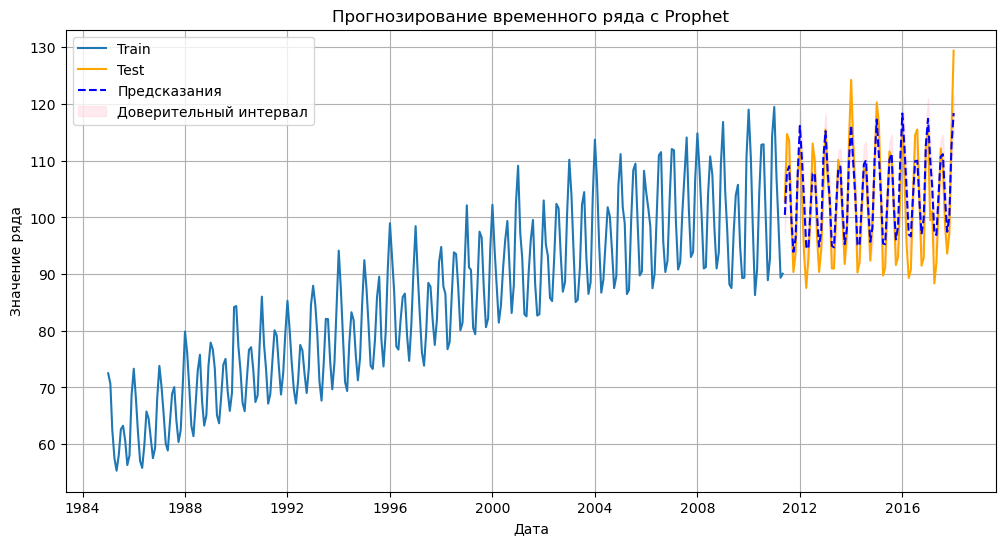

In [28]:
# График
plt.figure(figsize=(12, 6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test", color="orange")
plt.plot(test["ds"], prophet_forecast, label="Предсказания", linestyle="dashed", color="blue")

# Добавляем доверительный интервал
plt.fill_between(test["ds"], 
                 forecast.iloc[-len(test):]["yhat_lower"], 
                 forecast.iloc[-len(test):]["yhat_upper"], 
                 color="pink", alpha=0.3, label="Доверительный интервал")

plt.legend()
plt.xlabel("Дата")
plt.ylabel("Значение ряда")
plt.title("Прогнозирование временного ряда с Prophet")
plt.grid()
plt.show()



В ходе работы выполнено предсказание временного ряда с помощью Sarima и Prophet.
Метрики модели Sarima - MAE: 4.64, RMSE: 5.89;
Метрики модели Sarima - MAE: 3.49, RMSE: 4.41.
Судя по метрикам, Prophet показал лучшие результаты.